In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
%matplotlib inline

In [2]:
class NumbersDataset(Dataset):
    def __init__(self, filepath, transforms=None, train=True, test=False):
        self.data = pd.read_csv(filepath)
        self.test = test
        if self.test == False:
            t_limit = int(self.data.shape[0] * 0.8)
            if train is True:
                self.data = self.data[:t_limit]
            else:
                self.data = self.data[t_limit:]
        self.transforms = transforms
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        if self.test == True:
            image = self.data.iloc[index,:].values.astype(np.uint8).reshape((28,28,1))
        else:
            image = self.data.iloc[index,1:].values.astype(np.uint8).reshape((28,28,1))
            label = self.data.iloc[index,0]
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        return image if self.test == True else (image, label)

In [3]:
train_data = NumbersDataset("../input/train.csv", transforms = transforms.ToTensor())
test_data = NumbersDataset("../input/train.csv",train=False, transforms = transforms.ToTensor())

#generating indices for train and validataion set
valid_size = 0.2
train_size = len(train_data)
indices = list(range(train_size))
np.random.shuffle(indices)
split = int(np.floor(valid_size * train_size))
valid_samples, train_samples = SubsetRandomSampler(indices[:split]), SubsetRandomSampler(indices[split:])


In [4]:
train_loader = DataLoader(train_data, batch_size= 10, sampler=train_samples)
dataiter = iter(train_loader)
images,labels = dataiter.next()

print(images.shape)

torch.Size([10, 1, 28, 28])


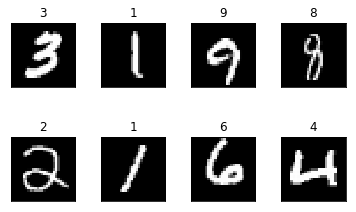

In [5]:
fig, axes = plt.subplots(ncols=4,nrows=2,subplot_kw={'yticks':[],'xticks':[]})
fig.subplots_adjust(hspace=0.1, wspace=0.4)
count = 1
for i in range(2):
    for j in range(4):
        img = np.squeeze(images[count])
        axes[i,j].imshow(img,cmap='gray')
        axes[i,j].set_title(labels[count].item())
        count += 1

In [6]:
#import torch deep learning modules
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class DigitClasificationCNN(nn.Module):
    
    def __init__(self):
        super(DigitClasificationCNN,self).__init__()
        
        #first convolution layer from 1d --> 5d, sees (1 X 28 x 28) tensor and outputs (32 X 28 X 28)
        self.conv_1 = nn.Conv2d(1, 32, 3, padding = 1)
        
        #sencond convolution layer from 5d --> 10d, sees (5 X 14 X 14) tensor and outputs (10 X 14 X 14)
        self.conv_2 = nn.Conv2d(32, 32, 3, padding = 1)
        
        #first max_pooling layer from (5 X 28 X 28) --> (5 X 14 X 14)
        self.pool_1 = nn.MaxPool2d(2,2)
        
        #first fully connected layer from (10 * 27 * 27) --> 1000
        self.fc_1 = nn.Linear(32 * 14 * 14, 128)
        
        #second fully connected layer from 1000 --> 500
        self.fc_2 = nn.Linear(128,10)
        
        #dropout layer to avoid overfitting
        self.drop_1 = nn.Dropout(0.25)
        
        #dropout layer to avoid overfitting
        self.drop_2 = nn.Dropout(0.5)
        
    def forward(self, x):
        
        x = F.relu(self.conv_1(x))
        
        x = F.relu(self.conv_2(x))
        
        x = self.drop_1(self.pool_1(x))
        
        x = x.view(-1, 32 * 14 * 14)
        
        x = self.drop_2(F.relu(self.fc_1(x)))
        
        x = self.fc_2(x)
        
        return x


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def train(model, train_loader, valid_loader, epochs = 10, lr = 0.001, print_every = 100):
    
    model = model.to(device)
    
    #defining loss function
    criterion = nn.CrossEntropyLoss()

    #defining optimizer
    optimizer = optim.Adam(model.parameters(),lr = lr)
    
    train_losses = []
    valid_losses = []
    counter = 0
    
    t_loss = []
    for epoch in range(1,epochs + 1):
        ######################
        # Training the model #
        ######################

        model.train()
        
        for data, target in train_loader:
            counter += 1

            #moving data to the coputing device(gpu/cpu)
            data = data.to(device)
            target = target.to(device)

            #clearing optimizer from gradients
            optimizer.zero_grad()

            #forward pass 
            output = model(data)

            #calculating the batch loss
            train_loss = criterion(output,target)

            #backward pass: calculating the gradient loss with respect to model parameters
            train_loss.backward()

            #performing optimization on the gradients
            optimizer.step()
            
            #########################
            # Validating the model #
            ########################
            if counter % print_every == 0:
                model.eval()
                valid_loss = []

                for data, target in valid_loader:

                    #moving data to the coputing device(gpu/cpu)
                    data = data.to(device)
                    target = target.to(device)

                    #forward pass
                    output = model(data)

                    #calculating the loss over the batch
                    loss = criterion(output, target)

                    valid_loss.append(loss.item())
                
                t_loss.append(train_loss.item())
                train_losses.append(np.mean(t_loss))
                valid_losses.append(np.mean(valid_loss))
                print("Epoch {}/{} \t Training loss: {} \t Validation loss: {}".format(epoch, epochs,train_losses[-1], valid_losses[-1]))

    return train_losses,valid_losses

In [10]:
batch_size = 128

#train and test data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_samples)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_samples)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [11]:
model = DigitClasificationCNN()
epochs = 20
lr = 0.001
train_l,valid_l = train(model, train_loader, valid_loader, epochs = epochs, lr=lr)

Epoch 1/20 	 Training loss: 0.47512173652648926 	 Validation loss: 0.2429736984788247
Epoch 1/20 	 Training loss: 0.30981601774692535 	 Validation loss: 0.1311333437432658
Epoch 2/20 	 Training loss: 0.2407187893986702 	 Validation loss: 0.09638576290376906
Epoch 2/20 	 Training loss: 0.1942765535786748 	 Validation loss: 0.07640662697969743
Epoch 3/20 	 Training loss: 0.18227630034089087 	 Validation loss: 0.07495374910814583
Epoch 3/20 	 Training loss: 0.15561570692807436 	 Validation loss: 0.06316855068336118
Epoch 4/20 	 Training loss: 0.14691924809345178 	 Validation loss: 0.06612823081185233
Epoch 4/20 	 Training loss: 0.13482528389431536 	 Validation loss: 0.056842201652954207
Epoch 5/20 	 Training loss: 0.12628226913511753 	 Validation loss: 0.06116419046554925
Epoch 5/20 	 Training loss: 0.11547013837844133 	 Validation loss: 0.04998287895940385
Epoch 6/20 	 Training loss: 0.11168202503838322 	 Validation loss: 0.06331871917365857
Epoch 6/20 	 Training loss: 0.1029257344392438

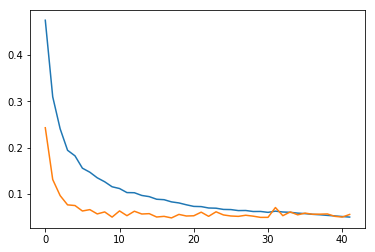

In [12]:
plt.plot(train_l)
plt.plot(valid_l)
plt.show()

In [13]:
#saving model 
model_name = "digit_mnist_cnn.net"

checkpoint = {
    'state_dict':model.state_dict()
}

with open(model_name,"wb") as mf:
    torch.save(checkpoint,mf)

In [14]:
def eval_model(model, data_loader):
    model.eval()
    preds = []
    for images, labels in data_loader:
        images = images.to(device)
        output = model(images)
        pred = F.log_softmax(output, dim=1)
        pred = torch.argmax(pred,dim=1)
        labels = labels.to(device)
        preds.append(torch.mean(torch.eq(pred,labels).to(device,dtype=torch.float32)).item())
    return np.mean(preds)

acc = eval_model(model, test_loader)
print("Test accuracy:{}".format(acc))

Test accuracy:0.9882102274533474


In [15]:
dataset = NumbersDataset("../input/test.csv", transforms=transforms.ToTensor(), test=True)
test_iter = DataLoader(dataset, batch_size=120, shuffle=False)

preds = np.array([])
model.eval()
for images in test_iter:
    
    images = images.to(device)
    output = model(images)
    pred = F.log_softmax(output, dim=1)
    pred = torch.argmax(pred,dim=1)
    pred = pred.cpu().numpy()
    preds = np.append(preds, pred)


In [16]:
preds = preds.astype(int)

preds_csv = pd.DataFrame(preds,columns=["Label"])
preds_csv.index +=1
preds_csv.to_csv("submissions.csv",index_label=["ImageId"])
